In [1]:
# M1 -> Cleaning, tidying and visualizations
# M2 -> Feature Engineering and pipeline
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set_theme()
from sklearn import preprocessing
import math
from sklearn import linear_model
from sklearn.neighbors import KNeighborsRegressor
#for reproducability
np.random.seed(42)

## Reading Data

In [2]:
root_path_happiness = 'Data/Happiness_Dataset'
world_happiness_2015_df = pd.read_csv(root_path_happiness + '/2015.csv')
world_happiness_2016_df = pd.read_csv(root_path_happiness + '/2016.csv')
world_happiness_2017_df = pd.read_csv(root_path_happiness + '/2017.csv')
world_happiness_2018_df = pd.read_csv(root_path_happiness + '/2018.csv')
world_happiness_2019_df = pd.read_csv(root_path_happiness + '/2019.csv')
life_expectancy_df = pd.read_csv('Data/Life Expectancy Data.csv')
country_data_df = pd.read_csv('Data/250 Country Data.csv')

In [3]:
def visualiseNaNCount(df):
  #Visualise NaNs
    numberNulls=[]
    columnNames=[]
    for (columnName, columnData) in df.iteritems():
            nan = df[columnName].isnull().sum()
            numberNulls.append(nan)
            columnNames.append(columnName)

    fig, ax = plt.subplots()
    ax.set_title('NaN count', fontdict={'fontsize': 12, 'fontweight': 'medium'})
    plt.bar(columnNames, numberNulls)
    plt.xticks(rotation=90)

    plt.show()

In [4]:
def EncodedCorrelationMap(df,var_to_encode):
    le = preprocessing.LabelEncoder()
    le.fit(df[var_to_encode])
    le.classes_
    df[var_to_encode] = le.transform(df[var_to_encode])
    sns.heatmap(df.corr())

# Life Expectancy Dataset

## Data Cleaning

## Tidying

In [5]:
life_expectancy_df.head()

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,...,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5


Using describe to have a general idea of the dataset

In [6]:
life_expectancy_df.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
count,2938.000000,2928.000000,2928.000000,2938.000000,2744.000000,2938.000000,2385.000000,2938.000000,2904.000000,2938.000000,2919.000000,2712.00000,2919.000000,2938.000000,2490.000000,2.286000e+03,2904.000000,2904.000000,2771.000000,2775.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,80.940461,2419.592240,38.321247,42.035739,82.550188,5.93819,82.324084,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793
std,4.613841,9.523867,124.292079,117.926501,4.052413,1987.914858,25.070016,11467.272489,20.044034,160.445548,23.428046,2.49832,23.716912,5.077785,14270.169342,6.101210e+07,4.420195,4.508882,0.210904,3.358920
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.37000,2.000000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.685343,77.000000,0.000000,19.300000,0.000000,78.000000,4.26000,78.000000,0.100000,463.935626,1.957932e+05,1.600000,1.500000,0.493000,10.100000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,92.000000,17.000000,43.500000,4.000000,93.000000,5.75500,93.000000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.534144,97.000000,360.250000,56.200000,28.000000,97.000000,7.49250,97.000000,0.800000,5910.806335,7.420359e+06,7.200000,7.200000,0.779000,14.300000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,99.000000,212183.000000,87.300000,2500.000000,99.000000,17.60000,99.000000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000


for easier access remove white space from beginning and end names of columns


In [7]:
life_expectancy_df.columns = life_expectancy_df.columns.str.lstrip()
life_expectancy_df.columns = life_expectancy_df.columns.str.rstrip()

Check the columns that we have

In [8]:
#columns
life_expectancy_df_columns = list(life_expectancy_df.columns)
life_expectancy_df_columns

['Country',
 'Year',
 'Status',
 'Life expectancy',
 'Adult Mortality',
 'infant deaths',
 'Alcohol',
 'percentage expenditure',
 'Hepatitis B',
 'Measles',
 'BMI',
 'under-five deaths',
 'Polio',
 'Total expenditure',
 'Diphtheria',
 'HIV/AIDS',
 'GDP',
 'Population',
 'thinness  1-19 years',
 'thinness 5-9 years',
 'Income composition of resources',
 'Schooling']

We need all column headers to represent variables, the problem is in the columns that represent stats about diseases

According to dataset description, the columns..
* measles represents the number of reported cases per 1000 
* HIV/AID represents the number of deaths per 1 000 live births HIV/AIDS (0-4 years)

We can rename the above to columns to be more reflective of what they represent, furthermore it seems that it would be pointless to melt them as they are not measured in the same units plus they are already variables

In addition, columns Hepatitis B, Polio, and Diphtheria represent the percentage of immunization coverage among 1-year-olds. These three columns can be melted in order to be represented as 2 columns: disease, immunization.

we rename columns to represent what they are


In [9]:
life_expectancy_df.rename(columns = {'HIV/AIDS':'HIV/AIDS Deaths'}, inplace = True) 
life_expectancy_df.rename(columns = {'Measles':'Number of reported Measles cases'}, inplace = True) 
life_expectancy_df
#Measles - number of reported cases per 1000 population
#HIV/AID Deaths per 1 000 live births HIV/AIDS (0-4 years)
#Hepatitis B (HepB) immunization coverage among 1-year-olds (%)
#Polio (Pol3) immunization coverage among 1-year-olds (%)
#Diphtheria tetanus toxoid and pertussis (DTP3) immunization coverage among 1-year-olds (%)

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Number of reported Measles cases,...,Polio,Total expenditure,Diphtheria,HIV/AIDS Deaths,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,...,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,...,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,...,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,...,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,...,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2933,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,68.0,31,...,67.0,7.13,65.0,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2
2934,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,7.0,998,...,7.0,6.52,68.0,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5
2935,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,73.0,304,...,73.0,6.53,71.0,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0
2936,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,76.0,529,...,76.0,6.16,75.0,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8


In [10]:
#diseses_columns = ['Hepatitis B','Polio','Diphtheria','Measles', 'HIV/AIDS']
#diseases_count_columns = ['Measles', 'HIV/AIDS']
immunization_columns = ['Hepatitis B','Polio','Diphtheria']
#melt immunization
new_columns =  [column for column in list(life_expectancy_df.columns) if not(column in immunization_columns)]  #print([s for s in l if s != 'Bob'])
life_expectancy_df_melted = pd.melt(life_expectancy_df,id_vars=new_columns,var_name="Disease", value_name="Immunization coverage")
life_expectancy_df_melted

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Number of reported Measles cases,BMI,...,Total expenditure,HIV/AIDS Deaths,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Disease,Immunization coverage
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,1154,19.1,...,8.16,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,Hepatitis B,65.0
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,492,18.6,...,8.18,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,Hepatitis B,62.0
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,430,18.1,...,8.13,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,Hepatitis B,64.0
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,2787,17.6,...,8.52,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,Hepatitis B,67.0
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,3013,17.2,...,7.87,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,Hepatitis B,68.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8809,Zimbabwe,2004,Developing,44.3,723.0,27,4.36,0.000000,31,27.1,...,7.13,33.6,454.366654,12777511.0,9.4,9.4,0.407,9.2,Diphtheria,65.0
8810,Zimbabwe,2003,Developing,44.5,715.0,26,4.06,0.000000,998,26.7,...,6.52,36.7,453.351155,12633897.0,9.8,9.9,0.418,9.5,Diphtheria,68.0
8811,Zimbabwe,2002,Developing,44.8,73.0,25,4.43,0.000000,304,26.3,...,6.53,39.8,57.348340,125525.0,1.2,1.3,0.427,10.0,Diphtheria,71.0
8812,Zimbabwe,2001,Developing,45.3,686.0,25,1.72,0.000000,529,25.9,...,6.16,42.1,548.587312,12366165.0,1.6,1.7,0.427,9.8,Diphtheria,75.0


In [11]:
life_expectancy_df_melted.describe()

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Number of reported Measles cases,BMI,under-five deaths,Total expenditure,HIV/AIDS Deaths,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Immunization coverage
count,8814.000000,8784.000000,8784.000000,8814.000000,8232.000000,8814.000000,8814.000000,8712.000000,8814.000000,8136.000000,8814.000000,7470.000000,6.858000e+03,8712.000000,8712.000000,8313.000000,8325.000000,8223.000000
mean,2007.518720,69.224932,164.796448,30.303948,4.602861,738.251295,2419.592240,38.321247,42.035739,5.938190,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,11.992793,82.003040
std,4.613317,9.522783,124.277927,117.913120,4.051920,1987.689279,11465.971238,20.041732,160.427342,2.498013,5.077208,14268.258627,6.100320e+07,4.419687,4.508364,0.210878,3.358516,24.023596
min,2000.000000,36.300000,1.000000,0.000000,0.010000,0.000000,0.000000,1.000000,0.000000,0.370000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,0.000000,1.000000
25%,2004.000000,63.100000,74.000000,0.000000,0.877500,4.673592,0.000000,19.300000,0.000000,4.260000,0.100000,463.852618,1.955530e+05,1.600000,1.500000,0.493000,10.100000,78.000000
50%,2008.000000,72.100000,144.000000,3.000000,3.755000,64.912906,17.000000,43.500000,4.000000,5.755000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.300000,93.000000
75%,2012.000000,75.700000,228.000000,22.000000,7.702500,441.844624,361.000000,56.200000,28.000000,7.492500,0.800000,5918.198980,7.423289e+06,7.200000,7.200000,0.779000,14.300000,97.000000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,212183.000000,87.300000,2500.000000,17.600000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000,99.000000


There are values of 0 for infant deaths

This does not make sense and probably was supposed to be a nan value.  This also applies to cases of measles, years of schooling, and under five deaths.

In [12]:
life_expectancy_df_melted['infant deaths'] = life_expectancy_df_melted['infant deaths'].replace({0: np.nan})
life_expectancy_df_melted['under-five deaths'] = life_expectancy_df_melted['under-five deaths'].replace({0: np.nan})
life_expectancy_df_melted['Schooling'] = life_expectancy_df_melted['Schooling'].replace({0: np.nan})
life_expectancy_df_melted['Number of reported Measles cases'] = life_expectancy_df_melted['Number of reported Measles cases'].replace({0: np.nan})

In [13]:
life_expectancy_df_melted.describe()


,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Number of reported Measles cases,BMI,under-five deaths,Total expenditure,HIV/AIDS Deaths,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,Immunization coverage
count,8814.000000,8784.000000,8784.000000,6270.000000,8232.000000,8814.000000,5865.000000,8712.000000,6459.000000,8136.000000,8814.000000,7470.000000,6.858000e+03,8712.000000,8712.000000,8313.000000,8241.000000,8223.000000
mean,2007.518720,69.224932,164.796448,42.599522,4.602861,738.251295,3636.195396,38.321247,57.362285,5.938190,1.742103,7483.158469,1.275338e+07,4.839704,4.870317,0.627551,12.115035,82.003040
std,4.613317,9.522783,124.277927,137.919414,4.051920,1987.689279,13898.176735,20.041732,185.048540,2.498013,5.077208,14268.258627,6.100320e+07,4.419687,4.508364,0.210878,3.148567,24.023596
min,2000.000000,36.300000,1.000000,1.000000,0.010000,0.000000,1.000000,1.000000,1.000000,0.370000,0.100000,1.681350,3.400000e+01,0.100000,0.100000,0.000000,2.800000,1.000000
25%,2004.000000,63.100000,74.000000,2.000000,0.877500,4.673592,17.000000,19.300000,3.000000,4.260000,0.100000,463.852618,1.955530e+05,1.600000,1.500000,0.493000,10.200000,78.000000
50%,2008.000000,72.100000,144.000000,9.000000,3.755000,64.912906,128.000000,43.500000,11.000000,5.755000,0.100000,1766.947595,1.386542e+06,3.300000,3.300000,0.677000,12.400000,93.000000
75%,2012.000000,75.700000,228.000000,33.000000,7.702500,441.844624,1212.000000,56.200000,46.000000,7.492500,0.800000,5918.198980,7.423289e+06,7.200000,7.200000,0.779000,14.300000,97.000000
max,2015.000000,89.000000,723.000000,1800.000000,17.870000,19479.911610,212183.000000,87.300000,2500.000000,17.600000,50.600000,119172.741800,1.293859e+09,27.700000,28.600000,0.948000,20.700000,99.000000


Much better.

## Getting rid of unnecessary columns
### This depends on our research questions

##### Our research questions are:

* What factors have a greater effect on happiness in developing VS developed countries ?
* How does happiness change over time for each region?
* How does population affect happiness?
* What is the effect of population density on adult mortality (density is population / area) in developing VS developed countries.
* How does life expectancy change over years?
* How does perception of corruption impact happiness over the years?
* How does immunization differ in developed VS non developed countries ? (type and percentage of immunization)

Therefore we will be dropping columns that are:
1. Completely unrelated to the above questions
2. Contain too many missing values to be considered to be providing important/interesting information.

In the case that a column contains nulls however is relevant / could show interesting insights during the data engineering phase it will be kept and imputed.


## Data Cleaning
### NaN handling

#### Check for NaN values. We use a bar graph because it is easier to see it visually

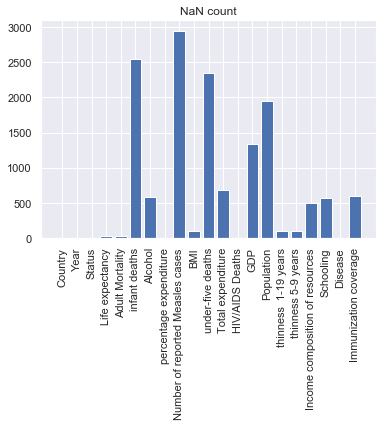

In [14]:
visualiseNaNCount(life_expectancy_df_melted)

The columns infant deaths, number of reported measles cases, and under-five deaths are nearly all missing data. They are not relevant to our research questions too. This gave us a good reason to drop them since imputing them would provide unnecessary noise in the data. In addition after research on Kaggle and exploring the data visually (scanning rows and columns) it has been concluded that BMI contains too many wrong values. It does not relate to our research questions so we will be dropping it too. In addition, population column is full of nans, and population is really hard to impute from the given variables; in addition the column population is present in the 250 countries dataset, and does not contain nulls. We can use it from there.

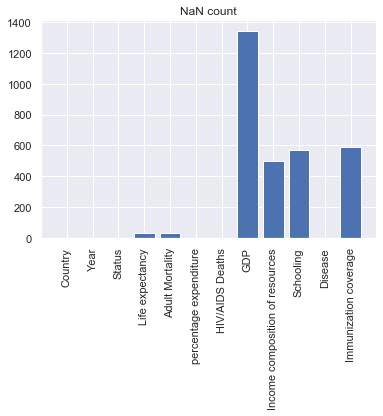

In [15]:
irrelevant_columns = ["infant deaths", "under-five deaths","Number of reported Measles cases","BMI","Alcohol","thinness  1-19 years","thinness 5-9 years","Total expenditure","Population" ]
life_expectancy_df_melted.drop(columns=irrelevant_columns, inplace = True)
visualiseNaNCount(life_expectancy_df_melted)

It was pointed out on Kaggle that Canada and Greece were incorrectly classified as developing countries, we correct that below.

In [16]:
#correcting some values
indices_canada = life_expectancy_df_melted.loc[life_expectancy_df_melted["Country"]=="Canada"].index
life_expectancy_df_melted.loc[indices_canada, ("Status")] = "Developed"

indices_canada = life_expectancy_df_melted.loc[life_expectancy_df_melted["Country"]=="Greece"].index
life_expectancy_df_melted.loc[indices_canada, ("Status")] = "Developed"

life_expectancy_df_melted.loc[life_expectancy_df_melted["Country"]=="Greece"].head()

,Country,Year,Status,Life expectancy,Adult Mortality,percentage expenditure,HIV/AIDS Deaths,GDP,Income composition of resources,Schooling,Disease,Immunization coverage
1026,Greece,2015,Developed,81.0,72.0,0.000000,0.1,187.78991,0.865,17.2,Hepatitis B,96.0
1027,Greece,2014,Developed,88.0,73.0,2163.043414,0.1,21673.78170,0.862,17.2,Hepatitis B,96.0
1028,Greece,2013,Developed,86.0,74.0,2183.106986,0.1,21874.81950,0.860,17.1,Hepatitis B,98.0
1029,Greece,2012,Developed,84.0,76.0,2528.992935,0.1,22242.68193,0.858,16.8,Hepatitis B,98.0
1030,Greece,2011,Developed,85.0,76.0,3192.887363,0.1,25916.29353,0.860,16.7,Hepatitis B,95.0


As we can see, the number of nulls is pretty high in population and GDP columns. Also in the total expenditure, income composition, schooling, immunization, and alcohol.

In order to treat the nulls, we have to use an imputation method. In this dataset we opt to imputation rather than dropping in order not to cause a bias/ data loss.
We examine the columns to see what is the best treatment method for each one.

#### Lets start with life expectancy
we start with the column with the least nans in case we resort to using it to impute other variables.

Is life expectancy missing completely at random or is there some relationship between missing life expectancies and other variables?

Perhaps developing counteries are less likely to report the life expectancy, perhaps due to limited surveying tools or overlooking the importance of keeping records

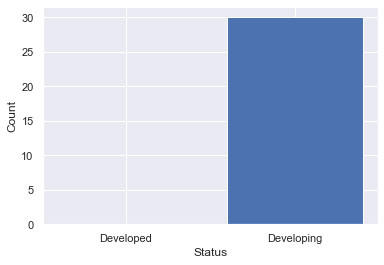

In [17]:
number_nans_life_expectancy_developed = life_expectancy_df_melted[life_expectancy_df_melted["Status"]=="Developed"]["Life expectancy"].isna().sum()
number_nans_life_expectancy_developing = life_expectancy_df_melted[life_expectancy_df_melted["Status"]=="Developing"]["Life expectancy"].isna().sum()
status = ["Developed","Developing"]
count = [number_nans_life_expectancy_developed,number_nans_life_expectancy_developing]
fig, ax = plt.subplots()
ax.bar(status,count)
ax.set_xlabel('Status')
ax.set_ylabel('Count')
plt.show()

Clearly, there is a strong relationship between the status of a country and reporting life expectancy.

In order to impute the nans, we need to see the relationship between life expectancy and other variables. A strong correlation between life expectancy and another variable means we can use it to estimate the nan by regression perhaps.


##### maybe if we can break the records down by year we would see an even stronger correlation
Intuitively, adult mortality and HIV/AIDS deaths would have a negative correletaion with life expectancy. As higher number of deaths (adult mortality) usually implies death of causes other than old age, whereas HIV/AIDS would cause a higher number of unnatural deaths too. We plot scatter plots to see if there is a correlation.

Below we break the data down by year then plot scatter plots to show how life expectancy correlates with other variables


In [18]:
developing_df = life_expectancy_df_melted.loc[life_expectancy_df_melted["Status"]=="Developing"]
developing_df_by_year ={}
years = developing_df.Year.unique()
for year in years:
    developing_df_by_year[str(year)] = developing_df[developing_df["Year"]==year]
    

Adult mortality and life expectancy


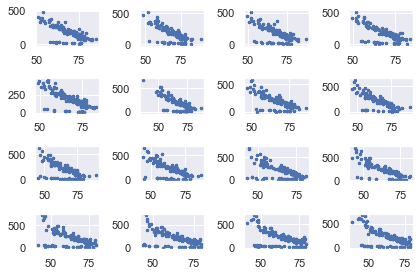

In [19]:
print("Adult mortality and life expectancy")
for i in range (1, 17):
    plt.subplot(4, 4, i)
    plt.scatter(developing_df_by_year[str(years[i-1])]["Life expectancy"], developing_df_by_year[str(years[i-1])]["Adult Mortality"], s=5)
    #plt.text(0.5,0.5, str((2, 3, i)), ha='center', fontsize = 10)
    plt.tight_layout()


#### Great! There is a strong negative correlation clearly between life expectancy and adult mortality. There are a few countries that do not follow the trend, lets explore why first in order to be able to know when and where we can generalise this relation. Furthermore, lets explore HIV/AIDS correlation

HIV/AIDS deaths and life expectancy


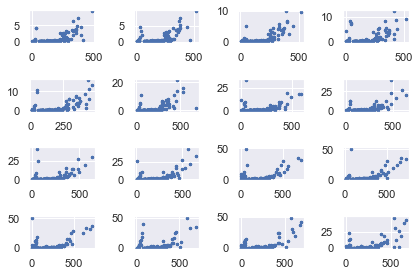

In [20]:
print("HIV/AIDS deaths and life expectancy")
for i in range (1, 17):
    plt.subplot(4, 4, i)
    plt.scatter(developing_df_by_year[str(years[i-1])]["Adult Mortality"], developing_df_by_year[str(years[i-1])]["HIV/AIDS Deaths"], s=5)
    #plt.text(0.5,0.5, str((2, 3, i)), ha='center', fontsize = 10)
    plt.tight_layout()

Not so strong correlation between HIV/AIDS deaths and life expectancy

Lets use pandas built in function that computes correlation between variables to see if any other variable correlates with life expectancy

In [21]:
developing_df.corr()["Life expectancy"]

Year                               0.189426
Life expectancy                    1.000000
Adult Mortality                   -0.657061
percentage expenditure             0.331051
HIV/AIDS Deaths                   -0.573542
GDP                                0.364453
Income composition of resources    0.632803
Schooling                          0.722065
Immunization coverage              0.400195
Name: Life expectancy, dtype: float64

Life expectancy positively correlates with years of schooling and income composition of resources. This also makes sense as higher education leads to more awareness and people are able to take care of their health better. Also income composition of resources represents an aspect of the human developement index which is by definition a statistical index composed of life expectancy, education (Literacy Rate, Gross Enrollment Ratio at different levels and Net Attendance Ratio), and per capita income indicators, which are used to rank countries into four tiers of human development. A country scores a higher HDI when the lifespan is higher, the education level is higher, and the gross national income (GNI) per capita is higher. In other words a higher HDI means a better quality of life.

Income composition of resources and life expectancy


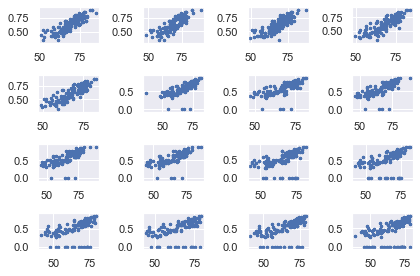

In [22]:
print("Income composition of resources and life expectancy")
for i in range (1, 17):
    plt.subplot(4, 4, i)
    plt.scatter(developing_df_by_year[str(years[i-1])]["Life expectancy"], developing_df_by_year[str(years[i-1])]["Income composition of resources"], s=5)
    #plt.text(0.5,0.5, str((2, 3, i)), ha='center', fontsize = 10)
    plt.tight_layout()

Years of schooling and life expectancy


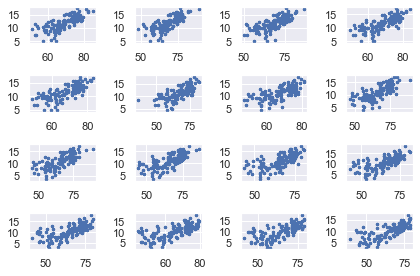

In [23]:
print("Years of schooling and life expectancy")
for i in range (1, 17):
    plt.subplot(4, 4, i)
    plt.scatter(developing_df_by_year[str(years[i-1])]["Life expectancy"], developing_df_by_year[str(years[i-1])]["Schooling"], s=5)
    #plt.text(0.5,0.5, str((2, 3, i)), ha='center', fontsize = 10)
    plt.tight_layout()

### Strong positive correlation from the above plots :)

We want to impute the life expectancy missing values. Where, the predictors (X) will be the features that strongly correlate with life expectancy and the life expectancy will be the Y to be predicted. 
The problem is, the predictors themselves have some values that contain nulls (they are in low number though). We need a way to impute these values and use them. Therefore we use multiple imputation using chained equations (MICE). In this method, we fill nans with a placeholder value. How to choose a placeholder? There are many ways such as: random sample, mean, median, mode. For skewed distributions it is best to use median, otherwise mean would work well. Then we pick a column, and revert the placeholder values to nans again and use the other columns to predict this value using regression. We iterate multiple times through this process, usually 10 iterations are done but it is just a rule of thumb.


#### Distribution
To choose a way to select a placeholder value, we would like to see how the variables are distributed. To view the distribution we need to plot a histogram. In order to be able to do that we need to determine an appropriate bin size, as a bin size too big or too small can lead to misleading information. One way to do that is to use the Freedman-Diaconis’s Rule. This formula uses the interquartile range (IQR), where the bin width = 2(IQR) $\sqrt[-3]{n}$ where n is the total number of observations. We implement a method to calculate this below.

In [24]:
def FreedmanRule(input_vector):
    #calculate IQR
    #print(input_vector)
    #using nan percentile to ignore nans
    q75, q25 = np.nanpercentile(input_vector, [75 ,25])
    #print(q25)
    iqr = q75 - q25
    #calculate Bin width
    bin_width = (2* iqr) / int(round(len(input_vector) ** (1. / 3)))
    return bin_width

Next, lets define a function that can draw a variable distribution

In [25]:
def drawDist(variable_to_display, title):
    print(title)
    bin_width = FreedmanRule(variable_to_display)
    num_bins = math.ceil((variable_to_display.max() - variable_to_display.min())/bin_width)
    ax = variable_to_display.plot.hist(bins=num_bins, alpha=0.5)

Life expectancy distribution


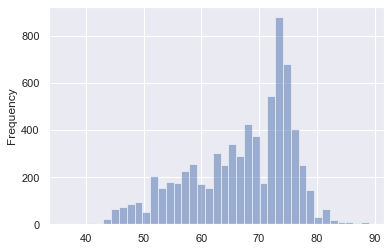

In [26]:
drawDist(developing_df["Life expectancy"], "Life expectancy distribution")

Life expectancy distribution is slightly skewed, making median a suitable placeholder.

Adult Mortality distribution


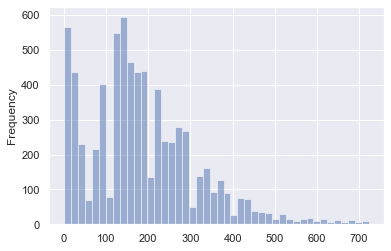

In [27]:
drawDist(developing_df["Adult Mortality"], "Adult Mortality distribution")

There is a greater skew here towards the left. In addition to it being bimodal. This also makes median a more suitable fit for a temporary placeholder than the mean.

Schooling distribution


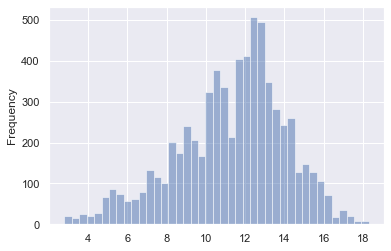

In [28]:
drawDist(developing_df["Schooling"], "Schooling distribution")

The distribution has a very slight skew, therefore we will also use the median

Income composition of resources distribution


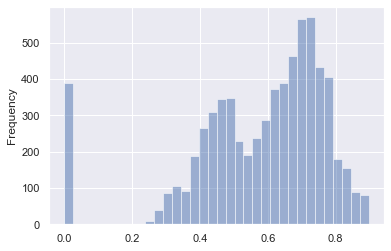

In [29]:
drawDist(developing_df["Income composition of resources"], "Income composition of resources distribution")

The distribution is pretty strange as there is a discontinuity. Perhaps samples drawn at random would be the suitable placeholders. Random sampling is selected in order to preserve the distribution as much as possible. It should be noted that we made sure that the 0 value is not a null by checking the documentation of the dataset.

#### Imputation


We define a function that can impute the missing values using median value. The median value will act as a temporary placeholder as described above. The values that are not null will be kept the same

In [30]:
def medianImputation(dataframe, feature):
    median = dataframe[feature].median()
    dataframe.loc[dataframe[feature].isnull(), (feature + '_temp')] = median
    return dataframe

Below is a brief demo of how median imputation works. Below we are trying to fill col3 with placeholders so we create a new column col3_temp and fill it with the placeholders (median) in place of nulls and leave other values as is.

In [31]:
dataframe_demo = pd.DataFrame({'col1': [1, np.nan,2], 'col2': [3, 3,4],'col3': [3,2, np.nan]})
print("Dataframe before \n")
print(dataframe_demo.head())
dataframe_demo["col3_temp"] = dataframe_demo["col3"]
dataframe_demo =medianImputation(dataframe_demo, "col3")
print("\n")
print("Dataframe after \n")
dataframe_demo

Dataframe before 

   col1  col2  col3
0   1.0     3   3.0
1   NaN     3   2.0
2   2.0     4   NaN


Dataframe after 



,col1,col2,col3,col3_temp
0,1.0,3,3.0,3.0
1,NaN,3,2.0,2.0
2,2.0,4,NaN,2.5


Implementing random imputer. It selects a number of obervations at random from the sample (non null observations). These are used for the placeholder values. Since we are randomising a process we specified a random seed above (very first cell) using np.random.seed(42). This allows for reproducible results due to the pseudo-random nature of computers.

In [32]:
def randomImputation(dataframe, feature):

    number_missing = dataframe[feature].isnull().sum()
    observed_values = dataframe.loc[dataframe[feature].notnull(), (feature)]
    dataframe.loc[dataframe[feature].isnull(), (feature + '_temp')] = np.random.choice(observed_values, number_missing, replace = True)

    return dataframe

Fill placeholders in 💪 Using median / random imputer depends on the feature as explained beforehand.

In [33]:
developing_df_imputed = developing_df.copy(deep=True)
columns_to_impute = ["Life expectancy", "Schooling", "Adult Mortality","Income composition of resources"]
for feature in columns_to_impute:
    developing_df_imputed[feature + '_temp'] = developing_df_imputed[feature]
    
    if(feature == "Income composition of resources"):
        developing_df_imputed = randomImputation(developing_df_imputed, feature)
    else:
        developing_df_imputed = medianImputation(developing_df_imputed, feature)
        
developing_df_imputed.isna().loc[:,("Life expectancy_temp", "Schooling_temp", "Adult Mortality_temp","Income composition of resources_temp")].sum()

Life expectancy_temp                    0
Schooling_temp                          0
Adult Mortality_temp                    0
Income composition of resources_temp    0
dtype: int64

As we can see, no more nans in the temp columns.

Next we are going to start imputing the values as described above. We will be imputing life expectancy.

In [34]:
paramters_for_life_expectancy = ["Schooling_temp", "Adult Mortality_temp", "Income composition of resources_temp"]
feature_to_impute = "Life expectancy"
#initialise model
model = linear_model.LinearRegression()
#fit model on data
model.fit(X = developing_df_imputed[paramters_for_life_expectancy], y = developing_df_imputed[feature_to_impute + '_temp'])
#this next step is done to maintain those ppoints that are not null
developing_df_imputed[feature_to_impute+"_imputed"] = developing_df_imputed[feature_to_impute] 
#those values that were originally null will be filled with the models predictions 
developing_df_imputed.loc[developing_df_imputed[feature_to_impute].isnull(),  (feature_to_impute+"_imputed")] = model.predict(developing_df_imputed[paramters_for_life_expectancy])[developing_df_imputed[feature_to_impute].isnull()]
print("number of nulls in imputed column: ",developing_df_imputed.isna().loc[:,("Life expectancy_imputed")].sum())
developing_df_imputed.loc[developing_df_imputed[feature_to_impute].isnull()].head()


number of nulls in imputed column:  0


,Country,Year,Status,Life expectancy,Adult Mortality,percentage expenditure,HIV/AIDS Deaths,GDP,Income composition of resources,Schooling,Disease,Immunization coverage,Life expectancy_temp,Schooling_temp,Adult Mortality_temp,Income composition of resources_temp,Life expectancy_imputed
624,Cook Islands,2013,Developing,NaN,NaN,0.000000,0.1,NaN,NaN,NaN,Hepatitis B,98.0,68.9,11.7,165.0,0.790,69.761682
769,Dominica,2013,Developing,NaN,NaN,11.419555,0.1,722.756650,0.721,12.7,Hepatitis B,96.0,68.9,12.7,165.0,0.721,70.527572
1650,Marshall Islands,2013,Developing,NaN,NaN,871.878317,0.1,3617.752354,NaN,NaN,Hepatitis B,8.0,68.9,11.7,165.0,0.589,68.129721
1715,Monaco,2013,Developing,NaN,NaN,0.000000,0.1,NaN,NaN,NaN,Hepatitis B,99.0,68.9,11.7,165.0,0.631,68.470728
1812,Nauru,2013,Developing,NaN,NaN,15.606596,0.1,136.183210,NaN,9.6,Hepatitis B,87.0,68.9,9.6,165.0,0.671,66.010654


In [35]:
developing_df_imputed.head()

,Country,Year,Status,Life expectancy,Adult Mortality,percentage expenditure,HIV/AIDS Deaths,GDP,Income composition of resources,Schooling,Disease,Immunization coverage,Life expectancy_temp,Schooling_temp,Adult Mortality_temp,Income composition of resources_temp,Life expectancy_imputed
0,Afghanistan,2015,Developing,65.0,263.0,71.279624,0.1,584.259210,0.479,10.1,Hepatitis B,65.0,65.0,10.1,263.0,0.479,65.0
1,Afghanistan,2014,Developing,59.9,271.0,73.523582,0.1,612.696514,0.476,10.0,Hepatitis B,62.0,59.9,10.0,271.0,0.476,59.9
2,Afghanistan,2013,Developing,59.9,268.0,73.219243,0.1,631.744976,0.470,9.9,Hepatitis B,64.0,59.9,9.9,268.0,0.470,59.9
3,Afghanistan,2012,Developing,59.5,272.0,78.184215,0.1,669.959000,0.463,9.8,Hepatitis B,67.0,59.5,9.8,272.0,0.463,59.5
4,Afghanistan,2011,Developing,59.2,275.0,7.097109,0.1,63.537231,0.454,9.5,Hepatitis B,68.0,59.2,9.5,275.0,0.454,59.2


In [36]:
#sns.histplot(developing_df_imputed["Life expectancy"].dropna(), kde = False)
#sns.histplot(developing_df_imputed[  "Life expectancy"+"_imputed"], kde = False, color = 'red')
#sns.boxplot(data = pd.concat([developing_df_imputed["Life expectancy"], developing_df_imputed["Life expectancy"+"_imputed"]], axis = 1))

#plt.tight_layout()


###### As we can see, the values that used to be null are not null anymore. Imputing by regression = success!
Lets do the same to other variables that are of interest to us.
We can sum up our imputation process in 4 broad steps:
1. Is there a relation between missing enteries and other variables?
2. Check correlation of column with missing variables with other columns to select suitable parameters that can approximate the nans.
3. Check if parameters contain nulls, if yes check the distribution of the parameters. If it is normal we can use mean as a placeholder value, if not median / random samples might be a better solution.
4. Train model and fit it, replace nans with predicted values from model.

Before we continue, we need to merge what we have just imputed into the main dataset.

In [37]:
#dropping temporary columns
developing_df_imputed.drop(columns=["Schooling_temp", "Adult Mortality_temp", "Income composition of resources_temp","Life expectancy_temp"],inplace = True)
#dropping old life expectancy column
developing_df_imputed.drop(columns=["Life expectancy"],inplace = True)
#rename the imputed column to "Life expectancy"
developing_df_imputed.rename(columns = {'Life expectancy_imputed':'Life expectancy'}, inplace = True)
#drop the old part from the original data set (the developing countries)
life_expectancy_df_melted = life_expectancy_df_melted[life_expectancy_df_melted['Status'] == "Developed"]

In [38]:
#concatenate the imputed part to the original df 
life_expectancy_df_melted=pd.concat([developing_df_imputed, life_expectancy_df_melted], sort = False)
print("Number of nulls in life expectancy now: ",life_expectancy_df_melted.isna().sum()["Life expectancy"])

Number of nulls in life expectancy now:  0


We continue these steps in the next section. Is there a relationship between values missing and other values? Lets consider the status just like we did before. We start by looking at the thinness

In [39]:
years = life_expectancy_df_melted.Year.unique()  #get which years contain records
years

array([2015, 2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005,
       2004, 2003, 2002, 2001, 2000], dtype=int64)

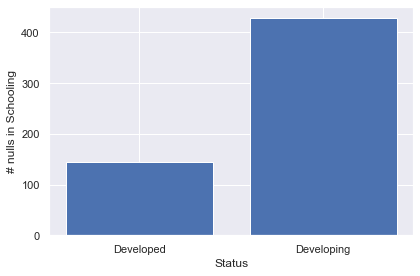

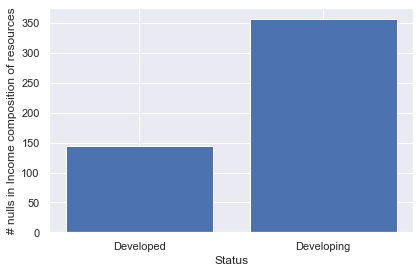

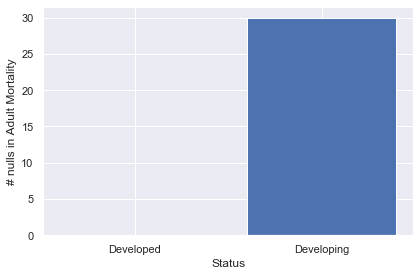

In [40]:
status = ["Developed","Developing"]
features_considered =["Schooling","Income composition of resources","Adult Mortality"]
for i in range (1, 4):
    number_nans_feature_developed = life_expectancy_df_melted[life_expectancy_df_melted["Status"]=="Developed"][features_considered[i-1]].isna().sum()
    number_nans_feature_developing = life_expectancy_df_melted[life_expectancy_df_melted["Status"]=="Developing"][features_considered[i-1]].isna().sum()
    count = [number_nans_feature_developed,number_nans_feature_developing]
    #plt.subplot(4, 4, i)
    fig, ax = plt.subplots()
    ax.bar(status,count)
    ax.set_xlabel('Status')
    ax.set_ylabel('# nulls in '+ str(features_considered[i-1]))
    plt.tight_layout()

Adult mortality follows the same trend as life expectancy, developing countries only do not report it. However Schooling and income composition of resources are missing at both. Could there be a relationship between years and missing values? As in during some years it was not a requirement for these values to be recorded.

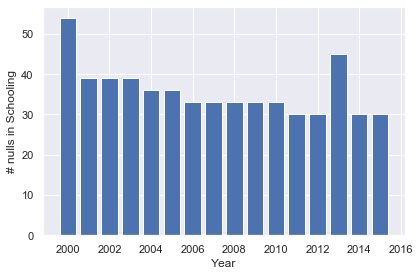

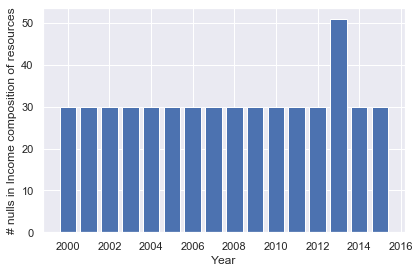

In [41]:
years = life_expectancy_df_melted.Year.unique()
features_considered =["Schooling","Income composition of resources"]
for i in range (1, 3):
    nans_per_year_arr =[]
    for year in years:
        number_nans_feature_year = life_expectancy_df_melted[life_expectancy_df_melted["Year"]==year][features_considered[i-1]].isna().sum()
        nans_per_year_arr.append(number_nans_feature_year)
    
    fig, ax = plt.subplots()
    ax.bar(years,nans_per_year_arr)
    ax.set_xlabel('Year')
    ax.set_ylabel('# nulls in '+ str(features_considered[i-1]))
    plt.tight_layout()

There seems to be few values missing every year, and there is no direct relationship between missingness and years as all years might have missing values. For some countries, the value of schooling is completely missing for all years recorded. The pattern of missingness indicates that there does not seem to be a relationship between the propensity of a value to be missing and its values, in other words it is not a MNAR. To elaborate on this, we have seen that the value could be missing when the country is developing or developed, values of these variables vary widely from developing to developed countries therefore we cannot claim that it is a MNAR. 

In order to impute the data, we need to check the correlation with the other variables. We will again split the data by developed and developing since the differences between the 2 categories is too big for us to be able to confidently generalise phenomena exhibited by members of one class of them to the other.

In [42]:
developing_df = life_expectancy_df_melted.loc[life_expectancy_df_melted["Status"]=="Developing"]
developed_df = life_expectancy_df_melted.loc[life_expectancy_df_melted["Status"]=="Developed"]
developing_df

,Country,Year,Status,Adult Mortality,percentage expenditure,HIV/AIDS Deaths,GDP,Income composition of resources,Schooling,Disease,Immunization coverage,Life expectancy
0,Afghanistan,2015,Developing,263.0,71.279624,0.1,584.259210,0.479,10.1,Hepatitis B,65.0,65.0
1,Afghanistan,2014,Developing,271.0,73.523582,0.1,612.696514,0.476,10.0,Hepatitis B,62.0,59.9
2,Afghanistan,2013,Developing,268.0,73.219243,0.1,631.744976,0.470,9.9,Hepatitis B,64.0,59.9
3,Afghanistan,2012,Developing,272.0,78.184215,0.1,669.959000,0.463,9.8,Hepatitis B,67.0,59.5
4,Afghanistan,2011,Developing,275.0,7.097109,0.1,63.537231,0.454,9.5,Hepatitis B,68.0,59.2
...,...,...,...,...,...,...,...,...,...,...,...,...
8809,Zimbabwe,2004,Developing,723.0,0.000000,33.6,454.366654,0.407,9.2,Diphtheria,65.0,44.3
8810,Zimbabwe,2003,Developing,715.0,0.000000,36.7,453.351155,0.418,9.5,Diphtheria,68.0,44.5
8811,Zimbabwe,2002,Developing,73.0,0.000000,39.8,57.348340,0.427,10.0,Diphtheria,71.0,44.8
8812,Zimbabwe,2001,Developing,686.0,0.000000,42.1,548.587312,0.427,9.8,Diphtheria,75.0,45.3


###### Imputing adult mortality
What are suitable predictors? Intuitively, life expectancy. Lets get the correlation of variables for developing countries. 

In [43]:
developing_df.corr()["Adult Mortality"]

Year                              -0.082268
Adult Mortality                    1.000000
percentage expenditure            -0.194814
HIV/AIDS Deaths                    0.514531
GDP                               -0.219508
Income composition of resources   -0.363311
Schooling                         -0.374472
Immunization coverage             -0.210048
Life expectancy                   -0.657061
Name: Adult Mortality, dtype: float64

As expected it negatively correlates with life expectancy. Also there is slight correlation with HIV/AIDS deaths. The correlation is stronger with life expectancy so we will use it. As we saw, life expectancy before has a slight skew so we will use median as a placeholder. We then train a model and fit it. Since we will fitting models often, we will define a function for it below. In addition to linear regression, K nearest neighbours can be used to impute the data. In this method, k neighbors are chosen based on a distance measure and their average is used as an imputation estimate. KNNs are very [powerful](https://www.tandfonline.com/doi/abs/10.1080/08839514.2019.1637138?src=recsys&journalCode=uaai20) and may sometimes out perform other imputation methods. Below, we use a KNN regressor to predict the nan values.

In [44]:
def create_model(dataframe,params, feature_to_impute, model_type , reshape):
    
    if(model_type == "LR"):
        model = linear_model.LinearRegression()
    else:
        model = KNeighborsRegressor(n_neighbors=2)
    #fit model on data
    if(reshape):
        XTrain =np.array(dataframe[params]).reshape(-1, 1)
    else:
        XTrain = dataframe[params]
        
        print(XTrain.isna().sum())
    model.fit(X = XTrain , y = dataframe[feature_to_impute + '_temp'])
    return model

In [45]:
developing_df_imputed = developing_df.copy(deep=True)
columns_to_impute = [ "Adult Mortality"]
for feature in columns_to_impute:
    developing_df_imputed[feature + '_temp'] = developing_df_imputed[feature]
    developing_df_imputed = medianImputation(developing_df_imputed, feature)
        
developing_df_imputed.isna().loc[:,("Adult Mortality_temp")].sum()
feature_to_impute =  "Adult Mortality"

model = create_model(developing_df_imputed,"Life expectancy",feature_to_impute, "KNN", True)
#this next step is done to maintain those points that are not null
developing_df_imputed[feature_to_impute+"_imputed"] = developing_df_imputed[feature_to_impute] 
developing_df_imputed.loc[developing_df_imputed[feature_to_impute].isnull(),  (feature_to_impute+"_imputed")] = model.predict(np.array(developing_df_imputed["Life expectancy"]).reshape(-1, 1))[developing_df_imputed[feature_to_impute].isnull()]
print("number of nulls in imputed column: ",developing_df_imputed.isna().loc[:,("Adult Mortality_imputed")].sum())
developing_df_imputed.loc[developing_df_imputed[feature_to_impute].isnull()].head()
    

number of nulls in imputed column:  0


,Country,Year,Status,Adult Mortality,percentage expenditure,HIV/AIDS Deaths,GDP,Income composition of resources,Schooling,Disease,Immunization coverage,Life expectancy,Adult Mortality_temp,Adult Mortality_imputed
624,Cook Islands,2013,Developing,NaN,0.000000,0.1,NaN,NaN,NaN,Hepatitis B,98.0,69.761682,165.0,91.5
769,Dominica,2013,Developing,NaN,11.419555,0.1,722.756650,0.721,12.7,Hepatitis B,96.0,70.527572,165.0,165.0
1650,Marshall Islands,2013,Developing,NaN,871.878317,0.1,3617.752354,NaN,NaN,Hepatitis B,8.0,68.129721,165.0,176.0
1715,Monaco,2013,Developing,NaN,0.000000,0.1,NaN,NaN,NaN,Hepatitis B,99.0,68.470728,165.0,188.0
1812,Nauru,2013,Developing,NaN,15.606596,0.1,136.183210,NaN,9.6,Hepatitis B,87.0,66.010654,165.0,194.0


Above we used KNN regressor to estimate the nans. KNN is simple, non parametric and intutive while Linear regression is parametric and often accurate. Each imputation method has its own strengths and weaknesses and using both of them is an attempt to utilise the power of both. 

After imputation we should merge the datasets together.

In [46]:
#dropping temporary columns
developing_df_imputed.drop(columns=[ "Adult Mortality_temp"],inplace = True)
#dropping old column
developing_df_imputed.drop(columns=["Adult Mortality"],inplace = True)
#rename the imputed column to "Adult Mortality"
developing_df_imputed.rename(columns = {'Adult Mortality_imputed':'Adult Mortality'}, inplace = True)
#drop the old part from the original data set (the developing countries)
life_expectancy_df_melted = life_expectancy_df_melted[life_expectancy_df_melted['Status'] == "Developed"]
life_expectancy_df_melted=pd.concat([developing_df_imputed, life_expectancy_df_melted], sort = False)
print("Number of nulls in mortality now: ",life_expectancy_df_melted.isna().sum()["Adult Mortality"])

Number of nulls in mortality now:  0


###### Imputing income composition of resources

In [47]:
developing_df = life_expectancy_df_melted.loc[life_expectancy_df_melted["Status"]=="Developing"]
developed_df = life_expectancy_df_melted.loc[life_expectancy_df_melted["Status"]=="Developed"]
display(developing_df.corr()["Income composition of resources"], developed_df.corr()["Income composition of resources"])

Year                               0.290926
percentage expenditure             0.325656
HIV/AIDS Deaths                   -0.205627
GDP                                0.376736
Income composition of resources    1.000000
Schooling                          0.703122
Immunization coverage              0.307533
Life expectancy                    0.632981
Adult Mortality                   -0.363271
Name: Income composition of resources, dtype: float64

Year                               3.900392e-01
percentage expenditure             4.635280e-01
HIV/AIDS Deaths                    3.207438e-14
GDP                                4.864520e-01
Income composition of resources    1.000000e+00
Schooling                          6.712646e-01
Immunization coverage             -1.252908e-01
Life expectancy                    7.176740e-01
Adult Mortality                   -4.793727e-01
Name: Income composition of resources, dtype: float64

Correlation differs by whether the country is developed or developing. However, both agree that the life expectancy and schooling are the variables that affect income composition of resources the most. Since the correlation is strong we use linear regression to estimate nans.

In [48]:
 life_expectancy_df_melted[life_expectancy_df_melted['Status'] == "Developing"]

,Country,Year,Status,percentage expenditure,HIV/AIDS Deaths,GDP,Income composition of resources,Schooling,Disease,Immunization coverage,Life expectancy,Adult Mortality
0,Afghanistan,2015,Developing,71.279624,0.1,584.259210,0.479,10.1,Hepatitis B,65.0,65.0,263.0
1,Afghanistan,2014,Developing,73.523582,0.1,612.696514,0.476,10.0,Hepatitis B,62.0,59.9,271.0
2,Afghanistan,2013,Developing,73.219243,0.1,631.744976,0.470,9.9,Hepatitis B,64.0,59.9,268.0
3,Afghanistan,2012,Developing,78.184215,0.1,669.959000,0.463,9.8,Hepatitis B,67.0,59.5,272.0
4,Afghanistan,2011,Developing,7.097109,0.1,63.537231,0.454,9.5,Hepatitis B,68.0,59.2,275.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8809,Zimbabwe,2004,Developing,0.000000,33.6,454.366654,0.407,9.2,Diphtheria,65.0,44.3,723.0
8810,Zimbabwe,2003,Developing,0.000000,36.7,453.351155,0.418,9.5,Diphtheria,68.0,44.5,715.0
8811,Zimbabwe,2002,Developing,0.000000,39.8,57.348340,0.427,10.0,Diphtheria,71.0,44.8,73.0
8812,Zimbabwe,2001,Developing,0.000000,42.1,548.587312,0.427,9.8,Diphtheria,75.0,45.3,686.0


In [49]:
developing_df_imputed = life_expectancy_df_melted[life_expectancy_df_melted['Status'] == "Developing"].copy(deep=True)
columns_of_interest = [ "Income composition of resources","Life expectancy","Schooling"]
for feature in columns_of_interest:
    developing_df_imputed[feature + '_temp'] = developing_df_imputed[feature]
    developing_df_imputed = medianImputation(developing_df_imputed, feature)
        
print(developing_df_imputed.isna().loc[:,("Income composition of resources_temp")].sum())
feature_to_impute =  "Income composition of resources"
print(developing_df_imputed[["Life expectancy","Schooling_temp"]].isna().sum())
model = create_model(developing_df_imputed,["Life expectancy","Schooling_temp"],feature_to_impute, "LG", False)
#this next step is done to maintain those points that are not null
developing_df_imputed[feature_to_impute+"_imputed"] = developing_df_imputed[feature_to_impute] 
developing_df_imputed.loc[developing_df_imputed[feature_to_impute].isnull(),  (feature_to_impute+"_imputed")] = model.predict(developing_df_imputed[ ["Life expectancy","Schooling_temp"]])[developing_df_imputed[feature_to_impute].isnull()]
print("number of nulls in imputed column: ",developing_df_imputed.isna().loc[:,(feature_to_impute+"_imputed")].sum())
developing_df_imputed.loc[developing_df_imputed[feature_to_impute].isnull()].head()

0
Life expectancy    0
Schooling_temp     0
dtype: int64
Life expectancy    0
Schooling_temp     0
dtype: int64
number of nulls in imputed column:  0


,Country,Year,Status,percentage expenditure,HIV/AIDS Deaths,GDP,Income composition of resources,Schooling,Disease,Immunization coverage,Life expectancy,Adult Mortality,Income composition of resources_temp,Life expectancy_temp,Schooling_temp,Income composition of resources_imputed
432,Côte d'Ivoire,2015,Developing,0.0,1.9,NaN,NaN,NaN,Hepatitis B,83.0,53.3,397.0,0.627,53.3,11.7,0.6270
433,Côte d'Ivoire,2014,Developing,0.0,2.0,NaN,NaN,NaN,Hepatitis B,76.0,52.8,47.0,0.627,52.8,11.7,0.6270
434,Côte d'Ivoire,2013,Developing,0.0,2.4,NaN,NaN,NaN,Hepatitis B,8.0,52.3,412.0,0.627,52.3,11.7,0.6270
435,Côte d'Ivoire,2012,Developing,0.0,2.9,NaN,NaN,NaN,Hepatitis B,82.0,52.0,415.0,0.627,52.0,11.7,0.3135
436,Côte d'Ivoire,2011,Developing,0.0,3.3,NaN,NaN,NaN,Hepatitis B,62.0,51.7,419.0,0.627,51.7,11.7,0.6270


In [50]:
#dropping temporary columns
developing_df_imputed.drop(columns=[ "Income composition of resources_temp","Life expectancy_temp","Schooling_temp"],inplace = True)
#dropping old column
developing_df_imputed.drop(columns=[feature_to_impute],inplace = True)
#rename the imputed column
developing_df_imputed.rename(columns = {feature_to_impute+"_imputed":feature_to_impute}, inplace = True)
#drop the old part from the original data set (the developing countries)
life_expectancy_df_melted = life_expectancy_df_melted[life_expectancy_df_melted['Status'] == "Developed"]
life_expectancy_df_melted=pd.concat([developing_df_imputed, life_expectancy_df_melted], sort = False)
print("Number of nulls in feature now: ",life_expectancy_df_melted.isna().sum()[feature_to_impute])

Number of nulls in feature now:  144


The remaining number of nulls is due to developed countries. Lets fix that.

In [51]:
developed_df_imputed = life_expectancy_df_melted[life_expectancy_df_melted['Status'] == "Developed"].copy(deep=True)
columns_of_interest = [ "Income composition of resources","Life expectancy","Schooling"]
for feature in columns_of_interest:
    developed_df_imputed[feature + '_temp'] = developed_df_imputed[feature]
    developed_df_imputed = medianImputation(developed_df_imputed, feature)
        
print(developed_df_imputed.isna().loc[:,("Income composition of resources_temp")].sum())
feature_to_impute =  "Income composition of resources"
print(developed_df_imputed[["Life expectancy","Schooling_temp"]].isna().sum())
model = create_model(developed_df_imputed,["Life expectancy","Schooling_temp"],feature_to_impute, "LG", False)
#this next step is done to maintain those points that are not null
developed_df_imputed[feature_to_impute+"_imputed"] = developed_df_imputed[feature_to_impute] 
developed_df_imputed.loc[developed_df_imputed[feature_to_impute].isnull(),  (feature_to_impute+"_imputed")] = model.predict(developed_df_imputed[ ["Life expectancy","Schooling_temp"]])[developed_df_imputed[feature_to_impute].isnull()]
print("number of nulls in imputed column: ",developed_df_imputed.isna().loc[:,(feature_to_impute+"_imputed")].sum())
developed_df_imputed.loc[developed_df_imputed[feature_to_impute].isnull()].head()

#dropping temporary columns
developed_df_imputed.drop(columns=[ "Income composition of resources_temp","Life expectancy_temp","Schooling_temp"],inplace = True)
#dropping old column
developed_df_imputed.drop(columns=[feature_to_impute],inplace = True)
#rename the imputed column
developed_df_imputed.rename(columns = {feature_to_impute+"_imputed":feature_to_impute}, inplace = True)
#drop the old part from the original data set (the developing countries)
life_expectancy_df_melted = life_expectancy_df_melted[life_expectancy_df_melted['Status'] == "Developing"]
life_expectancy_df_melted=pd.concat([developed_df_imputed, life_expectancy_df_melted], sort = False)
print("Number of nulls in feature now: ",life_expectancy_df_melted.isna().sum()[feature_to_impute])

0
Life expectancy    0
Schooling_temp     0
dtype: int64
Life expectancy    0
Schooling_temp     0
dtype: int64
number of nulls in imputed column:  0
Number of nulls in feature now:  0


In [52]:
developing_df = life_expectancy_df_melted.loc[life_expectancy_df_melted["Status"]=="Developing"]
developed_df = life_expectancy_df_melted.loc[life_expectancy_df_melted["Status"]=="Developed"]
display(developing_df.corr()["Schooling"], developed_df.corr()["Schooling"])

Year                               0.235090
percentage expenditure             0.352814
HIV/AIDS Deaths                   -0.195853
GDP                                0.379683
Schooling                          1.000000
Immunization coverage              0.382308
Life expectancy                    0.722197
Adult Mortality                   -0.374301
Income composition of resources    0.703106
Name: Schooling, dtype: float64

Year                               2.683703e-01
percentage expenditure             1.914622e-01
HIV/AIDS Deaths                    2.012466e-15
GDP                                1.560929e-01
Schooling                          1.000000e+00
Immunization coverage             -1.622034e-01
Life expectancy                    3.954299e-01
Adult Mortality                   -2.425213e-01
Income composition of resources    6.712646e-01
Name: Schooling, dtype: float64

The correlation factor differs, but in both cases life expectancy and income composition are strong influencers.

In [53]:
def merge_dataframes(dataframe,original_dataframe,columns_to_drop, column_old, column_new, status_to_keep):
    #dropping temporary columns
    dataframe.drop(columns=columns_to_drop,inplace = True)
    #rename the imputed column
    dataframe.rename(columns = {column_old:column_new}, inplace = True)
    #drop the old part from the original data set 
    original_dataframe = original_dataframe[original_dataframe['Status'] == status_to_keep]
    original_dataframe=pd.concat([dataframe, original_dataframe], sort = False)
    print("Number of nulls in feature now: ",original_dataframe.isna().sum()[column_new])
    return original_dataframe
    

In [54]:
def preprocess_dataframe(status, columns_of_interest,feature_to_impute, model_type, reshape):
    dataframe = life_expectancy_df_melted[life_expectancy_df_melted['Status'] == status].copy(deep=True)
    for feature in columns_of_interest:
        dataframe[feature + '_temp'] = dataframe[feature]
        dataframe = medianImputation(dataframe, feature)
        
    dataframe[feature_to_impute + '_temp'] = dataframe[feature_to_impute]
    dataframe = medianImputation(dataframe, feature_to_impute)

    print(dataframe.isna().loc[:,(feature_to_impute +"_temp")].sum())
    
    model = create_model(dataframe,[feature_preprocessed + "_temp" for feature_preprocessed in columns_of_interest],feature_to_impute, model_type, reshape)
    #this next step is done to maintain those points that are not null
    dataframe[feature_to_impute+"_imputed"] = dataframe[feature_to_impute] 
    features_preprocessed = [feature_preprocessed + "_temp" for feature_preprocessed in columns_of_interest]
    dataframe.loc[dataframe[feature_to_impute].isnull(),  (feature_to_impute+"_imputed")] = model.predict(dataframe[features_preprocessed])[dataframe[feature_to_impute].isnull()]
    print("number of nulls in imputed column: ",dataframe.isna().loc[:,(feature_to_impute+"_imputed")].sum())
    dataframe.loc[dataframe[feature_to_impute].isnull()].head()
    return dataframe

In [55]:
developed_dataframe_processed = preprocess_dataframe("Developed", ["Life expectancy", "Income composition of resources"], "Schooling", "LG", False)
original_dataframe = merge_dataframes(developed_dataframe_processed,life_expectancy_df_melted, ["Life expectancy_temp", "Income composition of resources_temp","Schooling_temp", "Schooling"], "Schooling_imputed", "Schooling", "Developing")
life_expectancy_df_melted = original_dataframe
life_expectancy_df_melted

0
Life expectancy_temp                    0
Income composition of resources_temp    0
dtype: int64
number of nulls in imputed column:  0
Number of nulls in feature now:  429


,Country,Year,Status,percentage expenditure,HIV/AIDS Deaths,GDP,Disease,Immunization coverage,Life expectancy,Adult Mortality,Income composition of resources,Schooling
112,Australia,2015,Developed,0.00000,0.1,56554.387600,Hepatitis B,93.0,82.8,59.0,0.937,20.4
113,Australia,2014,Developed,10769.36305,0.1,62214.691200,Hepatitis B,91.0,82.7,6.0,0.936,20.4
114,Australia,2013,Developed,11734.85381,0.1,67792.338600,Hepatitis B,91.0,82.5,61.0,0.933,20.3
115,Australia,2012,Developed,11714.99858,0.1,67677.634770,Hepatitis B,91.0,82.3,61.0,0.930,20.1
116,Australia,2011,Developed,10986.26527,0.1,62245.129000,Hepatitis B,92.0,82.0,63.0,0.927,19.8
...,...,...,...,...,...,...,...,...,...,...,...,...
8809,Zimbabwe,2004,Developing,0.00000,33.6,454.366654,Diphtheria,65.0,44.3,723.0,0.407,9.2
8810,Zimbabwe,2003,Developing,0.00000,36.7,453.351155,Diphtheria,68.0,44.5,715.0,0.418,9.5
8811,Zimbabwe,2002,Developing,0.00000,39.8,57.348340,Diphtheria,71.0,44.8,73.0,0.427,10.0
8812,Zimbabwe,2001,Developing,0.00000,42.1,548.587312,Diphtheria,75.0,45.3,686.0,0.427,9.8


In [56]:
developing_dataframe_processed = preprocess_dataframe("Developing", ["Life expectancy", "Income composition of resources"], "Schooling", "LG", False)
original_dataframe = merge_dataframes(developing_dataframe_processed,life_expectancy_df_melted, ["Life expectancy_temp", "Income composition of resources_temp", "Schooling_temp","Schooling"], "Schooling_imputed", "Schooling", "Developed")
life_expectancy_df_melted = original_dataframe
life_expectancy_df_melted

0
Life expectancy_temp                    0
Income composition of resources_temp    0
dtype: int64
number of nulls in imputed column:  0
Number of nulls in feature now:  0


,Country,Year,Status,percentage expenditure,HIV/AIDS Deaths,GDP,Disease,Immunization coverage,Life expectancy,Adult Mortality,Income composition of resources,Schooling
0,Afghanistan,2015,Developing,71.279624,0.1,584.259210,Hepatitis B,65.0,65.0,263.0,0.479,10.1
1,Afghanistan,2014,Developing,73.523582,0.1,612.696514,Hepatitis B,62.0,59.9,271.0,0.476,10.0
2,Afghanistan,2013,Developing,73.219243,0.1,631.744976,Hepatitis B,64.0,59.9,268.0,0.470,9.9
3,Afghanistan,2012,Developing,78.184215,0.1,669.959000,Hepatitis B,67.0,59.5,272.0,0.463,9.8
4,Afghanistan,2011,Developing,7.097109,0.1,63.537231,Hepatitis B,68.0,59.2,275.0,0.454,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...
8681,United States of America,2004,Developed,0.000000,0.1,NaN,Diphtheria,96.0,77.5,111.0,0.862,15.8
8682,United States of America,2003,Developed,0.000000,0.1,NaN,Diphtheria,96.0,77.2,114.0,0.862,15.8
8683,United States of America,2002,Developed,0.000000,0.1,NaN,Diphtheria,94.0,77.0,115.0,0.862,15.8
8684,United States of America,2001,Developed,0.000000,0.1,NaN,Diphtheria,94.0,76.9,115.0,0.862,15.8


Below we follow the same pipeline for immunization coverage and GDP

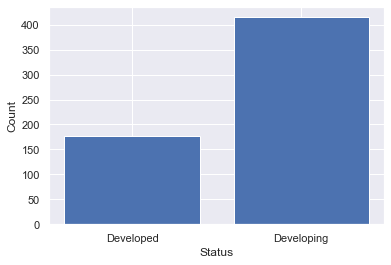

In [57]:
number_nans_life_expectancy_developed = life_expectancy_df_melted[life_expectancy_df_melted["Status"]=="Developed"]["Immunization coverage"].isna().sum()
number_nans_life_expectancy_developing = life_expectancy_df_melted[life_expectancy_df_melted["Status"]=="Developing"]["Immunization coverage"].isna().sum()
status = ["Developed","Developing"]
count = [number_nans_life_expectancy_developed,number_nans_life_expectancy_developing]
fig, ax = plt.subplots()
ax.bar(status,count)
ax.set_xlabel('Status')
ax.set_ylabel('Count')
plt.show()

In [58]:
developing_df.corr()["Immunization coverage"]

Year                               0.116334
percentage expenditure             0.116927
HIV/AIDS Deaths                   -0.128600
GDP                                0.167314
Schooling                          0.382308
Immunization coverage              1.000000
Life expectancy                    0.399315
Adult Mortality                   -0.209394
Income composition of resources    0.300699
Name: Immunization coverage, dtype: float64

There isnt much correlation  between immunization and anything, maybe then KNN regressor would be a better choice for imputation. We pick the variables that would intuitively be related to immunization as features to the regressor.

In [59]:
developed_dataframe_processed = preprocess_dataframe("Developed", ["Life expectancy", "Schooling"], "Immunization coverage", "KNN", False)
original_dataframe = merge_dataframes(developed_dataframe_processed,life_expectancy_df_melted, ["Life expectancy_temp", "Schooling_temp","Immunization coverage_temp", "Immunization coverage"], "Immunization coverage_imputed", "Immunization coverage", "Developing")
life_expectancy_df_melted = original_dataframe
life_expectancy_df_melted

0
Life expectancy_temp    0
Schooling_temp          0
dtype: int64
number of nulls in imputed column:  0
Number of nulls in feature now:  415


,Country,Year,Status,percentage expenditure,HIV/AIDS Deaths,GDP,Disease,Life expectancy,Adult Mortality,Income composition of resources,Schooling,Immunization coverage
112,Australia,2015,Developed,0.00000,0.1,56554.387600,Hepatitis B,82.8,59.0,0.937,20.4,93.0
113,Australia,2014,Developed,10769.36305,0.1,62214.691200,Hepatitis B,82.7,6.0,0.936,20.4,91.0
114,Australia,2013,Developed,11734.85381,0.1,67792.338600,Hepatitis B,82.5,61.0,0.933,20.3,91.0
115,Australia,2012,Developed,11714.99858,0.1,67677.634770,Hepatitis B,82.3,61.0,0.930,20.1,91.0
116,Australia,2011,Developed,10986.26527,0.1,62245.129000,Hepatitis B,82.0,63.0,0.927,19.8,92.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8809,Zimbabwe,2004,Developing,0.00000,33.6,454.366654,Diphtheria,44.3,723.0,0.407,9.2,65.0
8810,Zimbabwe,2003,Developing,0.00000,36.7,453.351155,Diphtheria,44.5,715.0,0.418,9.5,68.0
8811,Zimbabwe,2002,Developing,0.00000,39.8,57.348340,Diphtheria,44.8,73.0,0.427,10.0,71.0
8812,Zimbabwe,2001,Developing,0.00000,42.1,548.587312,Diphtheria,45.3,686.0,0.427,9.8,75.0


In [60]:
developing_dataframe_processed = preprocess_dataframe("Developing", ["Life expectancy", "Schooling"], "Immunization coverage", "KNN", False)
original_dataframe = merge_dataframes(developing_dataframe_processed,life_expectancy_df_melted, ["Life expectancy_temp", "Schooling_temp","Immunization coverage_temp", "Immunization coverage"], "Immunization coverage_imputed", "Immunization coverage", "Developed")
life_expectancy_df_melted = original_dataframe
life_expectancy_df_melted

0
Life expectancy_temp    0
Schooling_temp          0
dtype: int64
number of nulls in imputed column:  0
Number of nulls in feature now:  0


,Country,Year,Status,percentage expenditure,HIV/AIDS Deaths,GDP,Disease,Life expectancy,Adult Mortality,Income composition of resources,Schooling,Immunization coverage
0,Afghanistan,2015,Developing,71.279624,0.1,584.259210,Hepatitis B,65.0,263.0,0.479,10.1,65.0
1,Afghanistan,2014,Developing,73.523582,0.1,612.696514,Hepatitis B,59.9,271.0,0.476,10.0,62.0
2,Afghanistan,2013,Developing,73.219243,0.1,631.744976,Hepatitis B,59.9,268.0,0.470,9.9,64.0
3,Afghanistan,2012,Developing,78.184215,0.1,669.959000,Hepatitis B,59.5,272.0,0.463,9.8,67.0
4,Afghanistan,2011,Developing,7.097109,0.1,63.537231,Hepatitis B,59.2,275.0,0.454,9.5,68.0
...,...,...,...,...,...,...,...,...,...,...,...,...
8681,United States of America,2004,Developed,0.000000,0.1,NaN,Diphtheria,77.5,111.0,0.862,15.8,96.0
8682,United States of America,2003,Developed,0.000000,0.1,NaN,Diphtheria,77.2,114.0,0.862,15.8,96.0
8683,United States of America,2002,Developed,0.000000,0.1,NaN,Diphtheria,77.0,115.0,0.862,15.8,94.0
8684,United States of America,2001,Developed,0.000000,0.1,NaN,Diphtheria,76.9,115.0,0.862,15.8,94.0


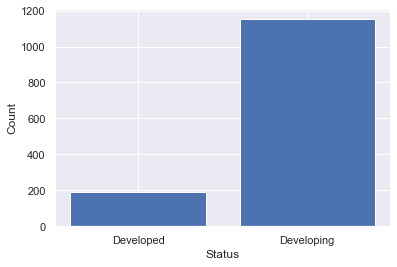

In [61]:
number_nans_life_expectancy_developed = life_expectancy_df_melted[life_expectancy_df_melted["Status"]=="Developed"]["GDP"].isna().sum()
number_nans_life_expectancy_developing = life_expectancy_df_melted[life_expectancy_df_melted["Status"]=="Developing"]["GDP"].isna().sum()
status = ["Developed","Developing"]
count = [number_nans_life_expectancy_developed,number_nans_life_expectancy_developing]
fig, ax = plt.subplots()
ax.bar(status,count)
ax.set_xlabel('Status')
ax.set_ylabel('Count')
plt.show()

In [62]:
developing_df.corr()["GDP"]

Year                               0.140719
percentage expenditure             0.847060
HIV/AIDS Deaths                   -0.108947
GDP                                1.000000
Schooling                          0.379683
Immunization coverage              0.167314
Life expectancy                    0.364213
Adult Mortality                   -0.219380
Income composition of resources    0.376832
Name: GDP, dtype: float64

Strong correlation with percentage expenditure, this is to be expected because pecentage expenditure represents the amount a goverment spends on health care.

In [63]:
developed_dataframe_processed = preprocess_dataframe("Developed", ["percentage expenditure"], "GDP", "LG", True)
original_dataframe = merge_dataframes(developed_dataframe_processed,life_expectancy_df_melted,["percentage expenditure_temp", "GDP_temp","GDP"], "GDP_imputed", "GDP", "Developing")
life_expectancy_df_melted = original_dataframe
life_expectancy_df_melted

0
number of nulls in imputed column:  0
Number of nulls in feature now:  1152


,Country,Year,Status,percentage expenditure,HIV/AIDS Deaths,Disease,Life expectancy,Adult Mortality,Income composition of resources,Schooling,Immunization coverage,GDP
112,Australia,2015,Developed,0.00000,0.1,Hepatitis B,82.8,59.0,0.937,20.4,93.0,56554.387600
113,Australia,2014,Developed,10769.36305,0.1,Hepatitis B,82.7,6.0,0.936,20.4,91.0,62214.691200
114,Australia,2013,Developed,11734.85381,0.1,Hepatitis B,82.5,61.0,0.933,20.3,91.0,67792.338600
115,Australia,2012,Developed,11714.99858,0.1,Hepatitis B,82.3,61.0,0.930,20.1,91.0,67677.634770
116,Australia,2011,Developed,10986.26527,0.1,Hepatitis B,82.0,63.0,0.927,19.8,92.0,62245.129000
...,...,...,...,...,...,...,...,...,...,...,...,...
8809,Zimbabwe,2004,Developing,0.00000,33.6,Diphtheria,44.3,723.0,0.407,9.2,65.0,454.366654
8810,Zimbabwe,2003,Developing,0.00000,36.7,Diphtheria,44.5,715.0,0.418,9.5,68.0,453.351155
8811,Zimbabwe,2002,Developing,0.00000,39.8,Diphtheria,44.8,73.0,0.427,10.0,71.0,57.348340
8812,Zimbabwe,2001,Developing,0.00000,42.1,Diphtheria,45.3,686.0,0.427,9.8,75.0,548.587312


In [64]:
developing_dataframe_processed = preprocess_dataframe("Developing",  ["percentage expenditure"], "GDP", "LG",  True)
original_dataframe = merge_dataframes(developing_dataframe_processed,life_expectancy_df_melted, ["percentage expenditure_temp", "GDP_temp","GDP"], "GDP_imputed", "GDP", "Developed")
life_expectancy_df_melted = original_dataframe
life_expectancy_df_melted

0
number of nulls in imputed column:  0
Number of nulls in feature now:  0


,Country,Year,Status,percentage expenditure,HIV/AIDS Deaths,Disease,Life expectancy,Adult Mortality,Income composition of resources,Schooling,Immunization coverage,GDP
0,Afghanistan,2015,Developing,71.279624,0.1,Hepatitis B,65.0,263.0,0.479,10.1,65.0,584.259210
1,Afghanistan,2014,Developing,73.523582,0.1,Hepatitis B,59.9,271.0,0.476,10.0,62.0,612.696514
2,Afghanistan,2013,Developing,73.219243,0.1,Hepatitis B,59.9,268.0,0.470,9.9,64.0,631.744976
3,Afghanistan,2012,Developing,78.184215,0.1,Hepatitis B,59.5,272.0,0.463,9.8,67.0,669.959000
4,Afghanistan,2011,Developing,7.097109,0.1,Hepatitis B,59.2,275.0,0.454,9.5,68.0,63.537231
...,...,...,...,...,...,...,...,...,...,...,...,...
8681,United States of America,2004,Developed,0.000000,0.1,Diphtheria,77.5,111.0,0.862,15.8,96.0,13832.755400
8682,United States of America,2003,Developed,0.000000,0.1,Diphtheria,77.2,114.0,0.862,15.8,96.0,13832.755400
8683,United States of America,2002,Developed,0.000000,0.1,Diphtheria,77.0,115.0,0.862,15.8,94.0,13832.755400
8684,United States of America,2001,Developed,0.000000,0.1,Diphtheria,76.9,115.0,0.862,15.8,94.0,13832.755400


### cleaning done, lets visualise nans to make sure no nans exist anymore

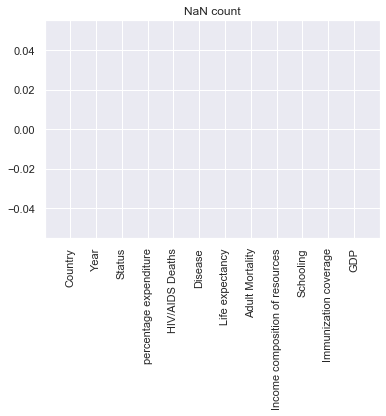

In [65]:
visualiseNaNCount(life_expectancy_df_melted)

No more nans!

# Exporting dataset

In [66]:
root_path='Cleaned_data/'
life_expectancy_df_melted.to_csv(root_path+'Life Expectancy Data.csv')

_Refrences:_

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3074241/

https://stats.stackexchange.com/questions/421545/multiple-imputation-by-chained-equations-mice-explained/421586

https://www.statisticshowto.com/choose-bin-sizes-statistics/